In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
import os
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

# supress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from scipy.stats import ttest_ind


import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/My Drive/airbnb/nyc-airbnb/'
files = os.listdir(root_path)
dates = [f[4:] for f in files if f.startswith('nyc')]
dates = sorted(dates)

In [4]:
dates

['2022-11-02',
 '2022-12-04',
 '2023-01-04',
 '2023-02-05',
 '2023-03-06',
 '2023-04-05',
 '2023-05-03',
 '2023-06-05',
 '2023-07-03',
 '2023-08-04',
 '2023-09-05',
 '2023-10-01']

In [5]:
dfs = {}
for date in dates:
  path = f'{root_path}nyc-{date}/listings.csv.gz'
  temp = pd.read_csv(path, compression = 'gzip')
  temp['price'] = temp['price'].str.replace("$", "").str.replace(",", "").astype(float)
  dfs[date] = temp

In [6]:
len(dfs['2022-11-02'])

39544

In [7]:
basic_info = []

for i in range(0, len(dates)):
  metrics = {
      'counts_of_listing': len(dfs[dates[i]]),
      'mean_of_price': dfs[dates[i]]['price'].mean(),
      'avg_avalibility_365': dfs[dates[i]]['availability_365'].mean(),
      'avg_number_review': dfs[dates[i]]['number_of_reviews'].mean()
  }
  if i == 0:
    metrics["drop"] = None
  else:
    cur = dfs[dates[i]]
    pre = dfs[dates[i - 1]]
    list_drop = [list_id for list_id in pre.id.values if list_id not in cur.id.values]
    metrics['drop'] = len(list_drop)
  basic_info.append(metrics)

metrics_df = pd.DataFrame(basic_info, index=pd.to_datetime(dates))
metrics_df

,counts_of_listing,mean_of_price,avg_avalibility_365,avg_number_review,drop
2022-11-02,39544,217.993071,135.607020,26.853176,NaN
2022-12-04,41533,221.978282,143.287771,26.204994,1327.0
2023-01-04,42754,194.558544,148.517589,25.929644,1809.0
2023-02-05,42739,187.747818,144.025340,25.879688,2820.0
2023-03-06,42931,200.307167,140.262211,25.856001,2197.0
2023-04-05,43241,210.992091,137.890567,25.751648,2133.0
2023-05-03,43303,216.099574,135.048011,25.995150,2173.0
2023-06-05,43566,225.216109,136.998256,26.368544,2125.0
2023-07-03,43729,217.068399,138.756272,26.789613,1827.0
2023-08-04,43582,212.093640,139.080194,26.971915,2056.0


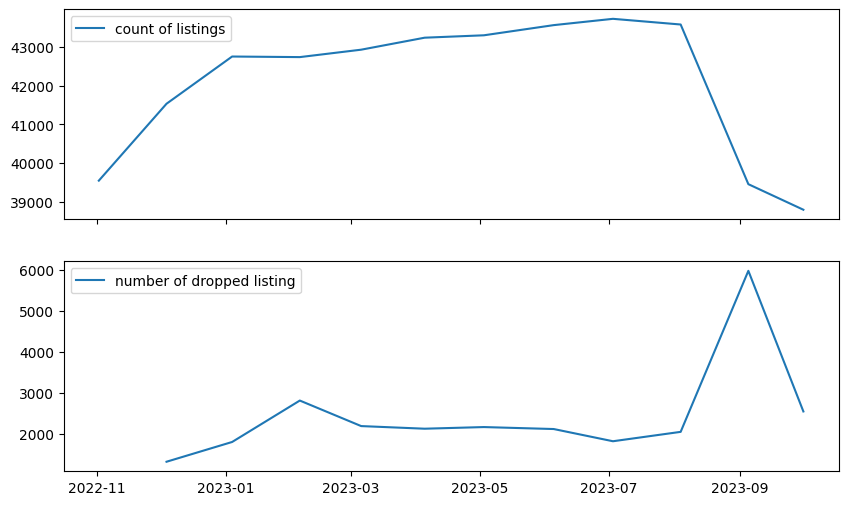

In [8]:
fig, ax = plt.subplots(2, figsize=[10,6], sharex=True)
ax[0].plot([pd.to_datetime(date) for date in dates],
 metrics_df['counts_of_listing'], label="count of listings")
ax[1].plot([pd.to_datetime(date) for date in dates],
 metrics_df['drop'], label="number of dropped listing")
ax[0].legend()
ax[1].legend()

In [9]:
before_df = dfs['2023-08-04']
after_df = dfs['2023-09-05']

In [10]:
id_drop = [id for id in before_df.id.values if id not in after_df.id.values]
before_df['dropped'] =  before_df['id'].isin(id_drop).astype(int)

In [11]:
len(id_drop)

5986

In [12]:
one_hot_encoded_df = pd.get_dummies(before_df['neighbourhood_group_cleansed'], prefix='neighborhood_')
before_df = before_df.join(one_hot_encoded_df)
before_df['instant_bookable_'] = before_df['instant_bookable'].map({'f': 0, 't': 1}).fillna(0)
before_df['host_is_superhost_'] = before_df['host_is_superhost'].map({'f':0, 't':1}).fillna(0)

In [13]:
x = before_df.copy()
## nights that greater than 30days becomes 1, otherwise 0
x["minimum_nights_30"] = x["minimum_nights"] // 30
x["minimum_nights_30"] = np.minimum(x["minimum_nights_30"], 1)

x["maximum_nights_30"] = x["maximum_nights"] // 30
x["maximum_nights_30"] = np.minimum(x["maximum_nights_30"], 1)
# x.groupby("minimum_nights_30")["dropped"].sum() / x.groupby("minimum_nights_30").apply(len)

x["accommodates_2"] = np.minimum(x["accommodates"]//2, 3)

x['host_since'] = pd.to_datetime(x['host_since'])
x['host_years'] = 2023 - x['host_since'].dt.year

x['instant_bookable_'] = x['instant_bookable'].map({'f': 0, 't': 1}).fillna(0)
x['host_is_superhost_'] = x['host_is_superhost'].map({'f':0, 't':1}).fillna(0)

x = x[x["price"] != 0]
x["log_price"] = np.log(x["price"])

x['constant'] = 1

x.groupby("neighbourhood_group_cleansed")["dropped"].sum() / x.groupby("neighbourhood_group_cleansed").apply(len)

neighbourhood_group_cleansed
Bronx            0.180622
Brooklyn         0.146737
Manhattan        0.114535
Queens           0.164307
Staten Island    0.136792
dtype: float64

In [14]:
before_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

x = before_df.copy()
## nights that greater than 30days becomes 1, otherwise 0
x["minimum_nights_30"] = x["minimum_nights"] // 30
x["minimum_nights_30"] = np.minimum(x["minimum_nights_30"], 1)

x["maximum_nights_30"] = x["maximum_nights"] // 30
x["maximum_nights_30"] = np.minimum(x["maximum_nights_30"], 1)
# x.groupby("minimum_nights_30")["dropped"].sum() / x.groupby("minimum_nights_30").apply(len)

x["accommodates_2"] = np.minimum(x["accommodates"]//2, 3)

x['host_since'] = pd.to_datetime(x['host_since'])
x['host_years'] = 2023 - x['host_since'].dt.year

x['instant_bookable_'] = x['instant_bookable'].map({'f': 0, 't': 1}).fillna(0)
x['host_is_superhost_'] = x['host_is_superhost'].map({'f':0, 't':1}).fillna(0)

x = x[x["price"] != 0]
x["log_price"] = np.log(x["price"])

x['constant'] = 1

x.groupby("neighbourhood_group_cleansed")["dropped"].sum() / x.groupby("neighbourhood_group_cleansed").apply(len)

x["host_listings_count"] = np.minimum(x["host_listings_count"], 2)

neighborhood_dummy = ['neighborhood__Bronx',
                      'neighborhood__Brooklyn',
                      # 'neighborhood__Manhattan',
                      'neighborhood__Queens',
                      'neighborhood__Staten Island']
minimum_nights_neighborhood = []
for nei in neighborhood_dummy:
  col = f"minimum_nights_{nei}"
  x[col] = x["minimum_nights_30"] * x[nei]
  minimum_nights_neighborhood.append(col)

scaler = StandardScaler()
scaler_needed_columns = ['log_price','availability_30',
                         'beds',
                         'host_listings_count',
                         'review_scores_rating',
                         #'number_of_reviews',
                         'host_years',
                         #'maximum_nights_30'
                         ]

x[scaler_needed_columns] = scaler.fit_transform(x[scaler_needed_columns])

initial_columns = scaler_needed_columns+['constant',
                                         'accommodates_2',
                                         'instant_bookable_',
                                         'host_is_superhost_'
                                         ] + neighborhood_dummy
x = x[x[initial_columns].notnull().all(axis=1)]
X = x[initial_columns]
y = x['dropped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
# lgr = LogisticRegression(class_weight='balanced')
# lgr.fit(X_train, y_train)
sm_model = sm.Logit(y_train, X_train)
sm_res = sm_model.fit()
y_pred_prob = sm_res.predict(X_test)
#p_pred = sm_res.predict_proba(X_test)

Optimization terminated successfully.
         Current function value: 0.676913
         Iterations 5


In [32]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]
z = pd.DataFrame({"test": y_test, "pred": y_pred})
z.groupby(["test","pred"]).apply(len)

test  pred
0     0       3246
      1       2251
1     0        434
      1        572
dtype: int64

In [33]:
sm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                dropped   No. Observations:                44240
Model:                          Logit   Df Residuals:                    44226
Method:                           MLE   Df Model:                           13
Date:                Mon, 27 Nov 2023   Pseudo R-squ.:                 0.02342
Time:                        19:39:28   Log-Likelihood:                -29947.
converged:                       True   LL-Null:                       -30665.
Covariance Type:            nonrobust   LLR p-value:                2.168e-299
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
log_price                       0.2752      0.016     17.737      0.000       0.245       0.306
availability_30                 0.0628      0.011      5.692      0.000       0.041       0.084
beds                           -0.0572      0.014     -4.024      0.000      -0.085      -0.029
host_listings_count            -0.0985      0.010     -9.568      0.000      -0.119      -0.078
review_scores_rating            0.0777      0.011      6.818      0.000       0.055       0.100
host_years                     -0.2757      0.011    -26.014      0.000      -0.296      -0.255
constant                        0.0599      0.028      2.134      0.033       0.005       0.115
accommodates_2                 -0.1385      0.018     -7.525      0.000      -0.175      -0.102
instant_bookable_              -0.1637      0.026     -6.324      0.000      -0.214      -0.113
host_is_superhost_              0.0057      0.023      0.250      0.803      -0.039       0.051
neighborhood__Bronx             0.0417      0.054      0.774      0.439      -0.064       0.147
neighborhood__Brooklyn          0.2018      0.023      8.624      0.000       0.156       0.248
neighborhood__Queens            0.2870      0.030      9.425      0.000       0.227       0.347
neighborhood__Staten Island    -0.8872      0.128     -6.919      0.000      -1.138      -0.636
===============================================================================================
"""

In [34]:
x.groupby("host_listings_count")["dropped"].sum() / x.groupby("host_listings_count").apply(len)

host_listings_count
-1.075001    0.157373
 0.930232    0.144212
dtype: float64

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.59      0.71      5497
           1       0.20      0.57      0.30      1006

    accuracy                           0.59      6503
   macro avg       0.54      0.58      0.50      6503
weighted avg       0.78      0.59      0.64      6503



In [36]:
confusion_matrix(y_test, y_pred)

array([[3246, 2251],
       [ 434,  572]])

In [37]:
feature_importance = pd.DataFrame({'coefficient':sm_res.params,
                                   'z_score': sm_res.tvalues,
                                   'p_value': sm_res.pvalues},
                                  index=X_train.columns).sort_values(by='z_score')
feature_importance['p_value'] = feature_importance['p_value'].map('{:.4f}'.format)


In [38]:
feature_importance

,coefficient,z_score,p_value
host_years,-0.275710,-26.014383,0.0000
host_listings_count,-0.098549,-9.567862,0.0000
accommodates_2,-0.138491,-7.524873,0.0000
neighborhood__Staten Island,-0.887175,-6.918758,0.0000
instant_bookable_,-0.163736,-6.323938,0.0000
beds,-0.057173,-4.023536,0.0001
host_is_superhost_,0.005714,0.249794,0.8027
neighborhood__Bronx,0.041709,0.774398,0.4387
constant,0.059908,2.133657,0.0329
availability_30,0.062775,5.692258,0.0000


ValueError: ignored

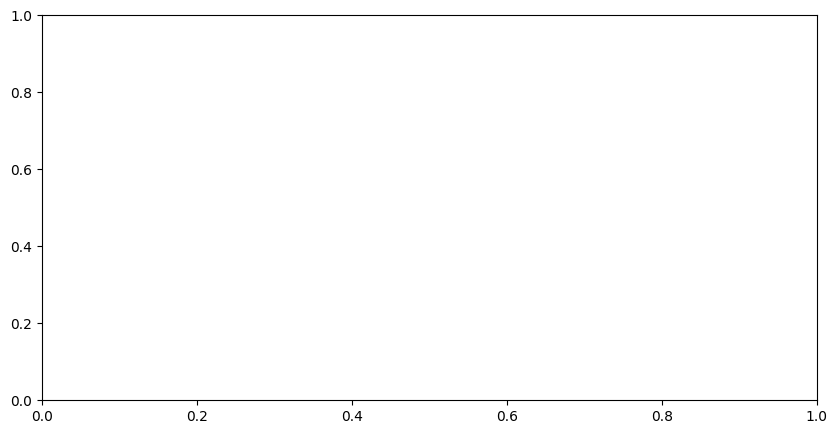

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
n = len(X_train.columns)
ax.bar(np.arange(n+1)+0.15, feature_importance['coefficient'], label = 'coefficient', width=0.3)
ax.bar(np.arange(n+1)-0.15, feature_importance['p_value'].astype(float), label = 'p_value', width=0.3)
ax.legend()
ax.set_title('Feature Importance (based on coefficient)')
ax.set_xticks(ticks=np.arange(n+1), labels=["const"]+columns, rotation=90)  # Rotate x-axis labels to avoid overlap
ax.grid()

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_prob_rf= rf_model.predict(X_test)
y_pred_rf = [1 if x > 0.5 else 0 for x in y_pred_prob_rf]

In [40]:
confusion_matrix(y_test, y_pred_rf)

array([[4990,  507],
       [ 797,  209]])

In [41]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      5497
           1       0.29      0.21      0.24      1006

    accuracy                           0.80      6503
   macro avg       0.58      0.56      0.56      6503
weighted avg       0.77      0.80      0.79      6503



In [42]:
rf_importance = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_importance
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)
rf_feature_importance


,feature,importance
0,log_price,0.227117
5,host_years,0.204727
4,review_scores_rating,0.191072
1,availability_30,0.184642
2,beds,0.054559
7,accommodates_2,0.036303
9,host_is_superhost_,0.023824
3,host_listings_count,0.020327
11,neighborhood__Brooklyn,0.018924
8,instant_bookable_,0.016799


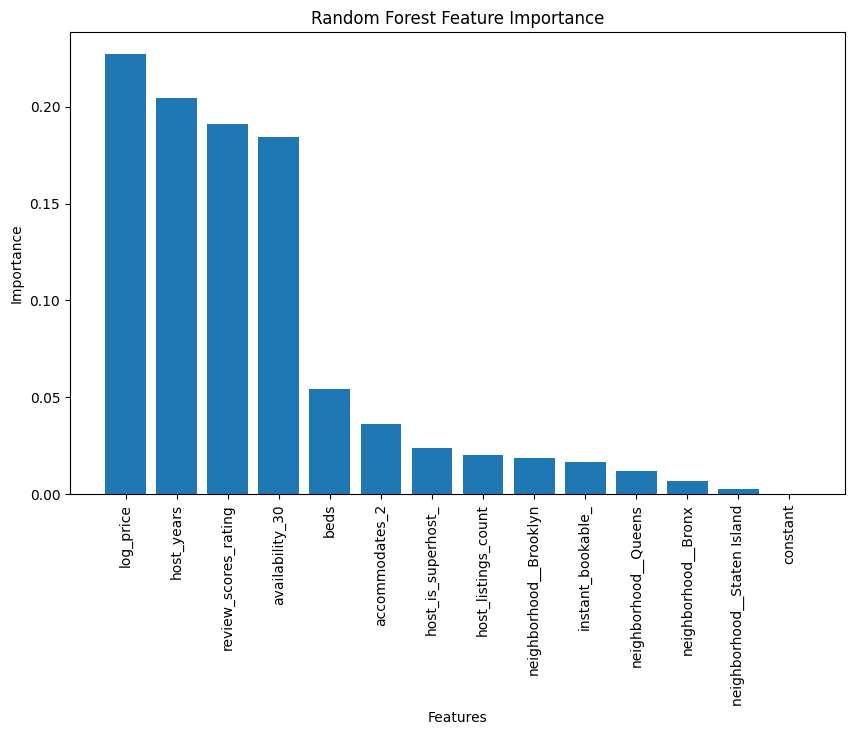

In [43]:
plt.figure(figsize=(10, 6))
plt.bar(rf_feature_importance['feature'], rf_feature_importance['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()